# Introduction to Convolutional Neural Networks, part 2

In [part 1](16_CNNs_part1.ipynb) of this section, we loaded the ASL data, visualized some sample images, normalized the data, and created and trained a model. That model had three layed, the first two had 512 neurons and the last had 25 and used the softmax activation function to generate a prediction that was the probablity that an image belonged to each of the 25 categories.

With that model, we achieved an accuract of about 80%.

We looked at some [slides on convolutional kernels, padding, pooling, dropout and data augmentation](https://docs.google.com/presentation/d/1uSk7xHWZ9H6YihUP4OdHpIVws_2py_HBfbby7GpZDCA/edit?usp=sharing). Now we can implement these.

## Reload and pre-process our data as in [part 1](16_CNNs_part1.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import os 
os.environ['KERAS_BACKEND'] = 'torch'

import keras
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image as image_utils



from helpers_plot_history import plot_history # Some helper functions for the CNN notebooks.

In [2]:
# Load the data
sign_train = pd.read_csv("data/sign_mnist/sign_mnist_train.csv")
sign_test = pd.read_csv("data/sign_mnist/sign_mnist_test.csv")

# Prepare X and y
y_train = sign_train['label']
X_train = sign_train.drop(columns='label').values

y_test = sign_test['label']
X_test = sign_test.drop(columns='label').values

# Normalize the data
X_train = X_train/255
X_test = X_test/255

# Convert our classes to categorical
num_classes = 25 # Not entirely sure what the 25th category is...

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Add Convolutional Kernels, Max Pooling, and Dropout

In part 1, we treated the image data as a row of 784 pixels. But our images are 28 rows of 28 pixels (a matrix of pixels). There is information in that spacial arrangement that is lost by simplifying the data into a row. 

Most computer vision tasks work best with the images in that matrix format. So, let's transform the data into the 28X28 shape.

### Reshape our data into a 28X28 matrix per image

In [3]:
print(f'Shape before: {X_train.shape}')
X_train = X_train.reshape(-1,28,28,1)
X_test= X_test.reshape(-1,28,28,1)

print(f'Shape after: {X_train.shape}')

Shape before: (27455, 784)
Shape after: (27455, 28, 28, 1)


### Our new model

Here's a diagram of the model that we'll use. There are *some* theoretical reasons behind this model, but a **lot** of it is "someone tried it and it worked well". 

![Diagram of the model implemented in code below](images/asl_model.png)


In [15]:
from keras.models import Sequential
from keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

In [16]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 50)     │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 25)       │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 25)       │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       205,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │        12,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,562 (1.01 MB)

 Trainable params: 264,262 (1.01 MB)

 Non-trainable params: 300 (1.17 KB)

In [17]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

In [7]:
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7561 - loss: 0.8350 - val_accuracy: 0.9142 - val_loss: 0.2725
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9924 - loss: 0.0236 - val_accuracy: 0.9345 - val_loss: 0.2568
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9965 - loss: 0.0113 - val_accuracy: 0.9032 - val_loss: 0.4732
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9978 - loss: 0.0067 - val_accuracy: 0.8903 - val_loss: 0.4965
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9984 - loss: 0.0045 - val_accuracy: 0.8137 - val_loss: 0.9920
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9985 - loss: 0.0038 - val_accuracy: 0.9671 - val_loss: 0.1196
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9746 - val_loss: 0.1266
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9992 - loss: 0.0022 - 

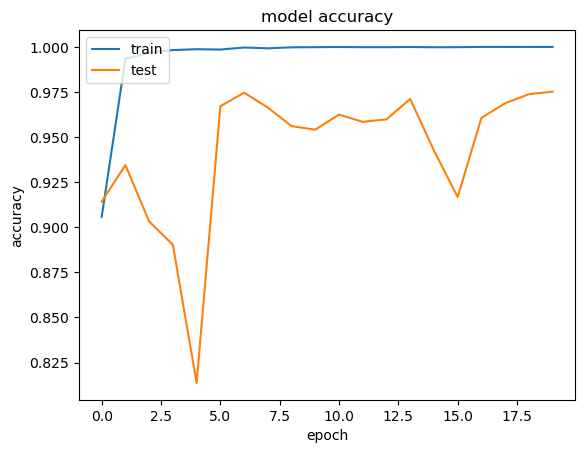

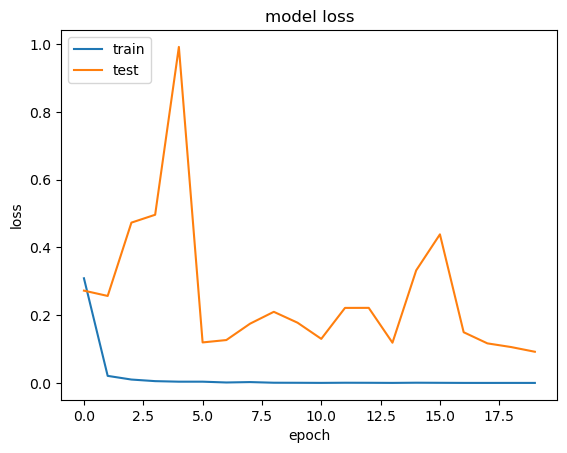

In [8]:
plot_history(history)

## Getting better, but still not great
### Add some data augmentation

This is implemented using a data flow generator. This image from Adrian Rosenbrock's article [Keras ImageDataGenerator and Data Augmentation](https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/) is a good summary:

![Data flow generator diagram](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2019/07/keras_data_augmentation_in_place.png?lossy=2&strip=1&webp=1)

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Define the augmentation pipeline
data_augmentation = keras.Sequential([
  keras.layers.RandomRotation(10/360),         # 10° rotation
  keras.layers.RandomTranslation(0.1, 0.1),      # width & height shifts of 10%
  keras.layers.RandomZoom(0.1, 0.1),             # zoom in/out up to 10%
  keras.layers.RandomFlip("horizontal")          # horizontal flip only
])

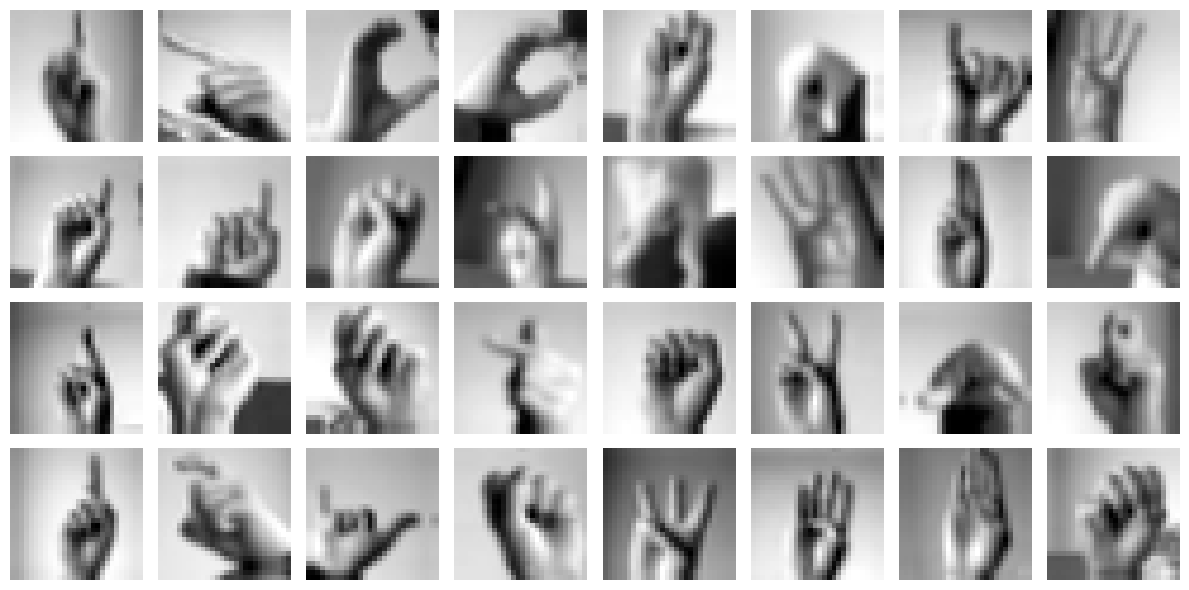

In [32]:
batch_size = 32
augmented_images = data_augmentation(X_train[:batch_size])
fig, ax = plt.subplots(4, 8, figsize=(12, 6))
for i in range(batch_size):
    ax.flatten()[i].imshow(np.squeeze(augmented_images[i].cpu()), cmap='gray')
    ax.flatten()[i].axis('off')
plt.tight_layout()
plt.show()

In [33]:
# Make a new model, adding the augmentation
aug_model = Sequential()
aug_model.add(data_augmentation)
aug_model.add(model)

# Compile the new model
aug_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
aug_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (32, 28, 28, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (32, 25)               │       264,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,562 (1.01 MB)

 Trainable params: 264,262 (1.01 MB)

 Non-trainable params: 300 (1.17 KB)

From the Nvidia notebooks:

> When using an image data generator with Keras, a model trains a bit differently: instead of just passing the `[X]_train` and `y_train` datasets into the model, we pass the generator in, calling the generator's [flow](https://keras.io/api/preprocessing/image/) method. This causes the images to get augmented live and in memory right before they are passed into the model for training.
>
> Generators can supply an indefinite amount of data, and when we use them to train our data, we need to explicitly set how long we want each epoch to run, or else the epoch will go on indefinitely, with the generator creating an indefinite number of augmented images to provide the model.
>
> We explicitly set how long we want each epoch to run using the `steps_per_epoch` named argument. Because `steps * batch_size = number_of_images_trained in an epoch` a common practice, that we will use here, is to set the number of steps equal to the non-augmented dataset size divided by the batch_size (which has a default value of 32).
>
> Run the following cell to see the results. The training will take longer than before, which makes sense given we are now training on more data than previously:

In [35]:
history = aug_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=6,
    validation_data=(X_test, y_test)
)
# Turned down epochs to 6 after running this. Took too long...

Epoch 1/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 142s 166ms/step - accuracy: 0.6044 - loss: 1.2938 - val_accuracy: 0.8765 - val_loss: 0.4313
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.8773 - loss: 0.3808 - val_accuracy: 0.9537 - val_loss: 0.1698
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.9218 - loss: 0.2415 - val_accuracy: 0.9611 - val_loss: 0.1247
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.9439 - loss: 0.1726 - val_accuracy: 0.9561 - val_loss: 0.1533
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.9514 - loss: 0.1519 - val_accuracy: 0.9868 - val_loss: 0.0527
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.9603 - loss: 0.1260 - val_accuracy: 0.9352 - val_loss: 0.2235
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.9647 - loss: 0.1123 - val_accuracy: 0.9377 - val_loss: 0.2091
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - accuracy: 0.9669 -

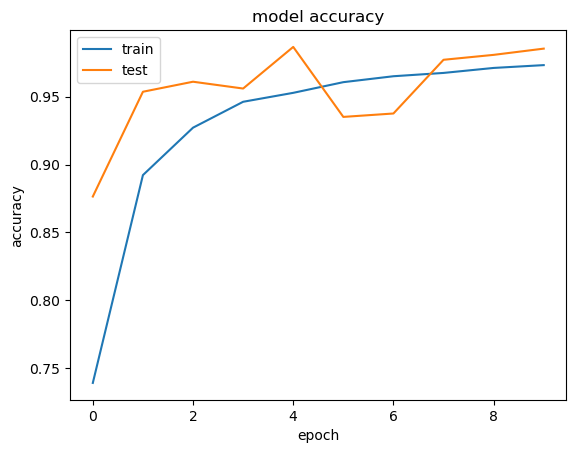

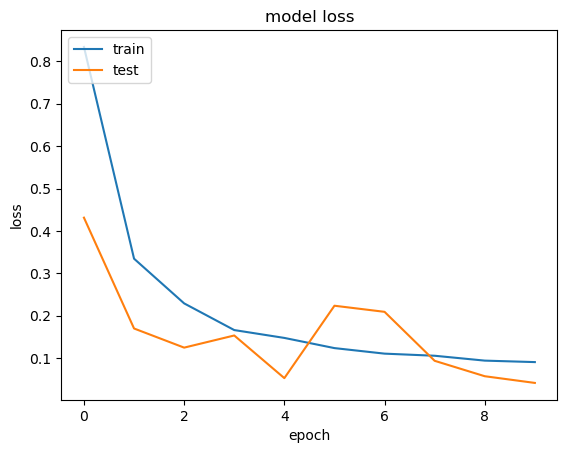

In [36]:
plot_history(history)

## Let's see how well the model does with new data

Let's play with some new images that aren't necessarily in the format the model was trained on. First we'll need to modify the new images to match what the model was trained on. The functions below help with that.

In [15]:
def show_image(image_path):
    '''Shows the image at a given path as it is.'''
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

def load_and_scale_image(image_path):
    '''Loads and scales the image to a 28x28 greyscale image, like the training data'''
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(28,28))
    return image

# Creates a dictionary to lookup what category number is what. 
# NOTE: this is based on there being 24 categories, we have 25, somehwere this will go wrong...
alphabet = "abcdefghijklmnopqrstuvwxy"
dictionary = {}
for i in range(24):
    dictionary[i] = alphabet[i]
dictionary

def predict_letter(file_path):
    '''Given an image, load it, scale for model and predict letter'''
    show_image(file_path)
    image = load_and_scale_image(file_path)
    image = image_utils.img_to_array(image)
    image = image.reshape(1,28,28,1) 
    image = image/255
    prediction = model.predict(image)
    print(prediction) # print the whole prediction array, probability for each category.
    # convert prediction to letter
    predicted_letter = dictionary[np.argmax(prediction)]
    return predicted_letter

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
[[6.0936854e-24 9.9999905e-01 2.1722820e-16 3.1636088e-15 2.7651230e-11
  8.9068385e-07 2.5849630e-20 1.0075474e-20 3.2344417e-14 2.1873643e-14
  1.5645999e-24 7.6424633e-17 4.4016193e-19 2.4698349e-22 2.7146518e-23
  4.0471377e-14 2.4380530e-23 1.6718943e-22 3.4368214e-20 6.9471427e-23
  1.1663741e-10 4.4602674e-28 1.3400357e-07 1.7360930e-14 2.6886369e-25]]


'b'

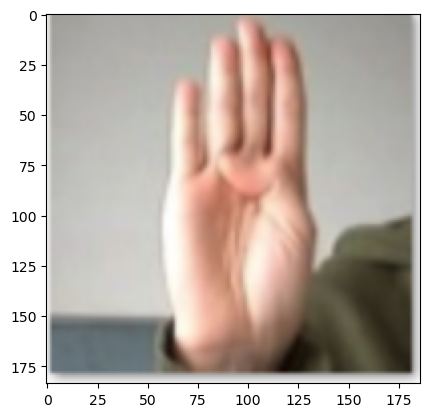

In [16]:
predict_letter("data/sign_mnist/b.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[1.2989266e-14 3.7288483e-15 4.6962950e-06 6.1753358e-21 3.9838572e-14
  4.7607367e-18 4.3375504e-16 1.2989046e-10 2.3342878e-17 1.5691742e-13
  4.7690813e-25 2.2408799e-21 5.4468382e-13 3.6599112e-13 9.0208697e-01
  2.7328762e-14 9.7908288e-02 2.1887366e-28 2.9546080e-20 5.3385842e-09
  1.7119588e-22 1.1502083e-25 1.1006274e-23 2.4246232e-14 2.7564685e-19]]


'o'

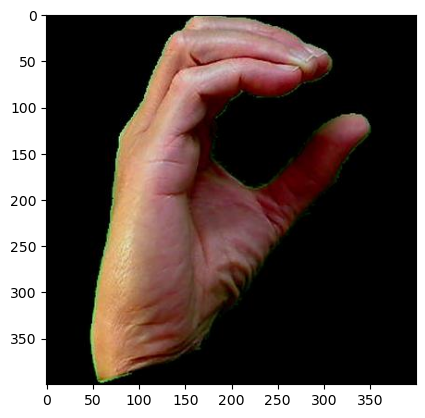

In [17]:
predict_letter('data/sign_mnist/c.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[1.5279145e-05 1.4012985e-44 5.7503528e-20 2.8152366e-40 1.2669407e-33
  7.5664183e-15 6.8692636e-27 1.6650986e-14 6.6482569e-32 4.6829573e-23
  0.0000000e+00 2.5731718e-33 8.1937565e-40 4.7413574e-31 9.9998474e-01
  1.4815326e-24 1.6874062e-24 0.0000000e+00 3.3772573e-30 4.1119986e-24
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0290481e-28 1.8418879e-36]]


'o'

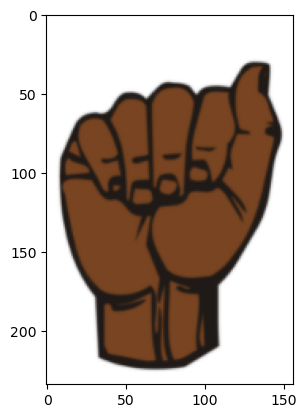

In [18]:
predict_letter('data/sign_mnist/a.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[[8.1921895e-35 0.0000000e+00 1.6191572e-17 4.8373767e-33 0.0000000e+00
  1.7922474e-28 6.5103604e-36 4.2744132e-25 4.2038954e-45 1.4502230e-34
  1.0436950e-36 1.0000000e+00 1.0298695e-34 6.2348318e-28 8.5362816e-37
  4.9589728e-33 4.4841551e-43 0.0000000e+00 0.0000000e+00 4.6995165e-28
  1.0754966e-41 5.0856592e-34 0.0000000e+00 3.3350903e-43 2.7968194e-33]]


'l'

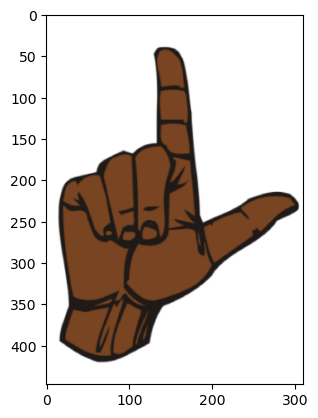

In [19]:
predict_letter('data/sign_mnist/l.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[1.5356836e-14 1.9755976e-19 6.0621127e-15 1.8852042e-15 8.3710669e-12
  1.0581899e-11 1.1975241e-09 2.0809551e-08 5.5778613e-13 6.6140843e-11
  5.8805510e-13 4.2906305e-18 2.4372445e-23 4.3489836e-02 3.0729664e-04
  9.5620263e-01 2.3881728e-07 2.7903519e-23 1.5763810e-09 6.0805959e-22
  6.1766547e-23 1.8708869e-26 9.7001713e-15 9.4497752e-09 1.9382835e-12]]


'p'

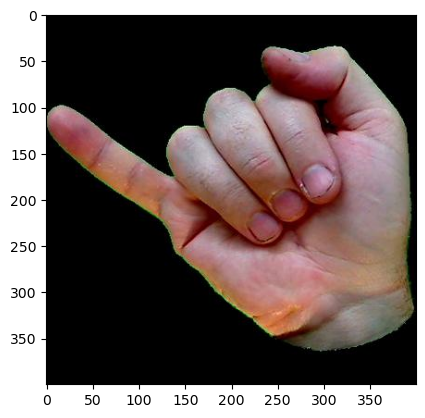

In [20]:
predict_letter('data/sign_mnist/j.jpeg')